Install Packages

In [ ]:
!pip install neuraloperator
!pip install deepxde

**Important**: Since we are using Google Colab make sure to mount your drive and 'cd' into the hw1 folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd '/YOUR/hw1/PATH/'

# Part 1: Fourier Neural Operator (FNO)

The following libraries will be necessary for your implementation.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import List, Union
from neuralop import Trainer
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from fno_block import FourierBlock
from spectral_convolution import SpectralConvolution
from mlp import MLP

# PyTorch random number generator
torch.manual_seed(1234)
np.random.seed(1234)

device = 'cpu'

---

## **Learning Objectives**

By the end of this assignment, you will be able to:

1.  Construct the FNO architecture by implementing its core components: lifting layers and spectral (Fourier) blocks.
2.   Understand the inputs and the outputs of the PDE dataset
3. Train and evaluate the FNO on Darcy Flow data to assess model performance.

---

## Fourier Neural Operator Architecture

The Fourier Neural Operator maps functions to functions using a sequence of Fourier-based layers. Below is the original diagram from the paper showing the full FNO pipeline.

![FNO Architecture](https://zongyi-li.github.io/neural-operator/img/fourier_full_arch5.png)

*Figure 1: Architecture of the Fourier Neural Operator (Li et al., 2020).*
[Source](https://arxiv.org/abs/2010.08895)


### Building the Fourier Neural Operator (FNO)

We will implement the Fourier Neural Operator (FNO) class, an advanced neural network model used for solving Partial Differential Equations (PDEs) through deep learning. The FNO utilizes Fourier transformations to learn global representations and can be particularly effective for high-dimensional data.

Let's start with the Fourier block which you will implement using the modules `SpectralConvolution` and `MLP`.

**Task 1: Implement the forward pass of the FourierBlock**
* You are given the constructor and you will have to work on the forward pass.

In [ ]:
class FourierBlock(nn.Module):
    """
    Fourier block used in the Fourier Neural Operator (FNO).
    Combines spectral convolution, MLP, and convolution layers.
    """
    def __init__(self, modes: Union[List[int], int], in_channels: int, out_channels: int,
                 hidden_size: int, activation: nn.Module = nn.GELU()) -> None:
        super().__init__()

        # Initialize the spectral convolution (Fourier layer)
        self.fourier = SpectralConvolution(in_channels, out_channels, modes)

        # MLP layer (which will do a linear transformation of the input)
        self.mlp = MLP(len(modes), in_channels, out_channels, hidden_size, activation)

        # Initialize the 2D convolution layer with kernel size of 3 and padding of 1
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)

        # Activation function for the block
        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the FourierBlock.

        Parameters:
        ----------
        x: torch.Tensor
            Input tensor of shape [batch, channels, *sizes]

        Returns:
        -------
        x: torch.Tensor
            Output tensor of shape [batch, channels, *sizes]
        """

        # TODO - Apply spectral convolution to input tensor
        x_ft = ...

        # TODO - Apply 2D convolution to input tensor
        x_conv = ...

        # Add the Fourier and convolution outputs
        x = x_ft + x_conv

        # TODO - Apply MLP to the result
        x_mlp = ...
        x = ...

        # TODO - Apply activation function to the final result
        return ...

**Task 2: Construst the FNO class**
*  Below is the skeleton of the `FNO` class. Certain parts are intentionally left blank for you to complete - **marked TODO for code you need to complete**. Follow the comments to understand what each part should accomplish.

In [ ]:
class FNO(nn.Module):
    """
    Fourier Neural Operator (FNO) for solving PDEs.
    """
    def __init__(self, modes: List[int], num_fourier_layers: int, in_channels: int,
                 lifting_channels: int, projection_channels: int, out_channels: int,
                 hidden_channels: int, activation: nn.Module):
        super().__init__()
        self.dim = len(modes)
        self.activation = activation

        # Lifting layer
        self.lifting = MLP(2, in_channels, hidden_channels, lifting_channels)

        # TODO - Initialize a list of num_fourier_layers FourierBlock modules
        #        with modes, hidden_channels, hidden_size and activation as parameters.
        #        You are free to choose which hidden_size is best for the model
        self.fourier_blocks = nn.ModuleList([
            ...
        ])

        # TODO - Use projection layers
        self.q1 = ...
        self.final = ...

    def forward(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        # TODO - Pass input to lifting layer
        x = ...

        # TODO - Pass the input through each FourierBlock sequentially
        for fourier_block in self.fourier_blocks:
            x = ...

        # Permute the dimensions back to [batch, sizes, channels].
        x = x.permute(0, *range(2, self.dim + 2), 1)

        # TODO - Apply projection and final layer
        x = ...
        x = ...
        x = ...

        # Permute to [batch, channels, sizes] format for output and return.
        return x.permute(0, -1, *range(1, self.dim + 1))

## Training the Fourier Neural Operator on Darcy Flow

### **Darcy Flow: Problem Statement**

We consider the steady-state form of the 2D Darcy Flow equation on the unit square domain. This is a second-order, linear, elliptic PDE given by:

$$
-\nabla \cdot \left( a(x) \nabla u(x) \right) = f(x), \quad x \in (0, 1)^2
$$

with Dirichlet boundary condition:

$$
u(x) = 0, \quad x \in \partial(0, 1)^2
$$

Here:
- $a(x) \in L^\infty((0, 1)^2; \mathbb{R}_+)$ is the **diffusion coefficient**
- $f(x) \in L^2((0, 1)^2; \mathbb{R})$ is the **forcing function**
- $u(x)$ is the **solution** (e.g., pressure field)

---

This PDE arises in many physical systems:
- Subsurface fluid pressure in porous media
- Deformation of elastic materials
- Electric potential in conductive materials

We aim to learn the **solution operator** that maps the coefficient $a(x)$ to the solution $u(x)$:

$$
a(x) \mapsto u(x)
$$

Even though the PDE is linear, the solution operator is **nonlinear** due to the dependence on the spatially varying coefficient $a(x)$.


---

### **Exploring the Darcy Flow Dataset**

You will load the data, visualize it, read the description to the dataset can be found [here](https://zenodo.org/records/12784353), and answer reflection questions.

**Loading the Darcy Flow dataset in 128x128 resolution:**

In [ ]:
# Load Darcy flow dataset
from pathlib import Path

data_root = Path("../data/")

train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=1000,
    batch_size=32,
    data_root=data_root,
    test_resolutions=[16, 32],
    n_tests=[100, 50],
    test_batch_sizes=[32, 32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [ ]:
help(load_darcy_flow_small)

Help on function load_darcy_flow_small in module neuralop.data.datasets.darcy:

load_darcy_flow_small(n_train, n_tests, batch_size, test_batch_sizes, data_root=PosixPath('/usr/local/lib/python3.11/dist-packages/neuralop/data/datasets/data'), test_resolutions=[16, 32], encode_input=False, encode_output=True, encoding='channel-wise', channel_dim=1)



**Run a quick visualization of the input and ground truth data**

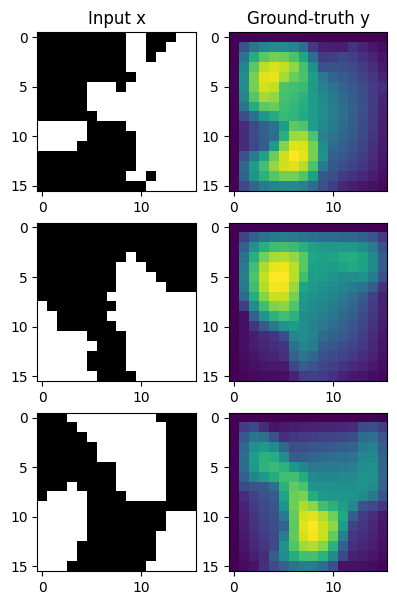

In [ ]:
#You can change the resolution from 16 to 32 to see the resolution difference if you'd like.
#Note: Because DeepONet trains and tests on same resolution, and our Darcy Flow dataset only contains training
# data of resolution 16, testing with 16 here is recommended for a better comparison (in DeepONet section of this HW).
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')


**Task 3: Reflection Prompt**

- What is the input x and how does it relate to the Darcy Flow equation?
- What does the output y represent in this context?

<style>
  .custom-background {
    background-color: #f4eb4eff;
    padding: 10px;
    border-radius: 5px;
  }
</style>
<div class="custom-background">
  Write your response here:
</div>

*  ...

* ...

### FNO Model

**Task 4: instance of our FNO model**
* Let's create an instance of our FNO model and tune the hyperparameters.

In [ ]:
# Initialize model
# TODO - Tune hyperparameters of FNO;
# hint: use small values for channels and no more than 6 layers
model = FNO(modes=[16, 16], num_fourier_layers=..., in_channels=1,
            lifting_channels=..., hidden_channels=..., projection_channels=...,
            out_channels=1, activation=nn.GELU())
model = model.to(device)

# Count model parameters
n_params = count_model_params(model)
print(f'\nModel parameters: {n_params}')

Create the optimizer and losses.

In [ ]:
# Losses and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {'h1': h1loss, 'l2': l2loss}

Visualize created instances for model and others.

In [ ]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')

Train the model using the trainer. For 20 epochs, it should take a few minutes only.

Aim for your `16_l2` metric (L2 loss in 16x16 resolution images) to be less than 0.5.

In [ ]:
# Train model
# eval_interval=3
trainer = Trainer(model=model, n_epochs=20, device=device, data_processor=data_processor,
                 use_distributed=False, verbose=True)
trainer.train(train_loader=train_loader, test_loaders=test_loaders,
              optimizer=optimizer, scheduler=scheduler,
              regularizer=False, training_loss=train_loss, eval_losses=eval_losses)

### Plot the prediction, and compare with the ground-truth

**Note:**
* We trained on images of low resolution for a small number of epochs. In practice, we would train at larger resolution, on many more samples and epochs.
* However, for practicality, we created a minimal example that:
  - fits in just a few Mb of memory
  - can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs.

In [ ]:
# Visualization of predictions
test_samples = test_loaders[32].dataset
fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')

fig.suptitle('Inputs, Ground-truth, and Model Prediction')
plt.tight_layout()
plt.savefig('neural_ops_output.png', dpi=500, bbox_inches='tight')
plt.show()

# Part 2: DeepONets

In this section, you will implement the DeepONet class, another advanced neural network model used for solving Partial Differential Equations (PDEs) through deep learning. The trunk and branch method in DeepONet allows for the separation of input functions and locations, enabling efficient and flexible learning of nonlinear operators by independently processing the function space and input space.

Below is the skeleton of the `DeepONet` class. Certain parts are intentionally left blank for you to complete - **marked TODO for code you need to complete**. Follow the comments to understand what each part should accomplish.

![Deep ONet Architecture](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs42256-021-00302-5/MediaObjects/42256_2021_302_Fig1_HTML.png?as=webp)

*Figure 1: Illustrations of the problem set-up and new architectures of DeepONets that lead to good generalization. (Lu et al., 2021).*
[Source](https://www.nature.com/articles/s42256-021-00302-5)

---

## **Learning Objectives**

By the end of this assignment, you will be able to:

1.  Construct the DeepONet architecture by implementing its two key components: the branch network (which encodes input functions) and the trunk network (which encodes evaluation coordinates).

2. Understand the role of each sub-network in the DeepONet framework, and how their outputs are combined to approximate an operator that maps input functions to solution functions.

---

<!-- **Goals**

1.   Construct Architecture
2.   Understanding what goes into each module branch and trunk -->



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim

### Training with DeepONet in Darcy flow

**Loading and extracting the Darcy Flow small dataset:**

Data Preparation

**Task 5: Create 2D spatial coordinates**

In [ ]:
# Load the Darcy flow dataset and reshape the input functions (u) and outputs (y) for DeepONet.

# Load Darcy Flow data
train_data = torch.load("../data/darcy_train_16.pt")
test_data = torch.load("../data/darcy_test_16.pt")

x_train = train_data["x"].float()  # shape: (1000, 16, 16)
y_train = train_data["y"].float()
x_test = test_data["x"].float()
y_test = test_data["y"].float()

# Flatten function input (u values) for branch net
X_branch_train = x_train.reshape(x_train.shape[0], -1)  # (1000, 256)
Y_branch_train = y_train.reshape(y_train.shape[0], -1)
X_branch_test = x_test.reshape(x_test.shape[0], -1)


# Trunk input:
# TODO: Create 2D spatial coordinates (shared across all samples)
H, W = x_train.shape[1], x_train.shape[2]
grid_x, grid_y = ...
X_trunk = ...  # (256, 2)


Model Definition (Unstacked DeepONet)

**Task 6: Implement DeepONet**
* Implement a simple dense neural net used for both branch and trunk
* Create the unstacked DeepONet class

In [ ]:
# TODO: Implement a simple dense neural net used for both branch and trunk
class DenseNet(nn.Module):
    def __init__(self, layers, activation=nn.ReLU):
        super().__init__()
        net = []
        # TODO: Build a nn.Sequential MLP using `layers` and the activation function
        for ...

        self.net = nn.Sequential(*net)

    def forward(self, x):
        # TODO: Forward through the built MLP and return the output
        return ...


# TODO: Create the unstacked DeepONet class using einsum to merge outputs from branch and trunk networks.
class DeepONet(nn.Module):
    """
    Unstacked DeepONet: merges branch and trunk outputs via an inner product.

    branch_net: maps input function samples u -> R^p      (shape: [B, p])
    trunk_net:  maps coords x -> R^p                      (shape: [N, p])

    """
    def __init__(self, branch_layers, trunk_layers):
        super().__init__()
        # TODO: Instantiate branch and trunk networks with DenseNet
        self.branch_net = ...
        self.trunk_net = ...

    def forward(self, u, coords):
        """
        u:      [B, u_dim]
        coords: [N, x_dim]
        Returns:
            y:  [B, N]
        """
        # TODO: Compute branch and trunk
        branch_out = ...
        trunk_out = ...
         # TODO: Merge with einsum
         # Hint: https://stackoverflow.com/questions/26089893/understanding-numpys-einsum
        return ...


In [ ]:
class LpLoss(object):
    '''
    loss function with rel/abs Lp loss
    from https://github.com/neuraloperator/physics_informed/blob/master/train_utils/losses.py#L152
    '''
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

**Task 7: Train your DeepONet**
* Define and tune hyperparameters
* Define your DeeopONet model
* Train the DeeopONet model

In [ ]:

# TODO: Hyperparameters
num_epochs = ...
learning_rate = ...

# Model initialization
in_dim = x_train.shape[-1] * x_train.shape[-2]  # 16×16 = 256
#TODO: Define branch and trunk layers
branch_layers = [in_dim, ..., ...]
trunk_layers = ...

model = DeepONet(branch_layers, trunk_layers).to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = LpLoss(size_average=True)

# TODO: Implement the training loop to minimize L2 loss over the predicted and true outputs.
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # TODO: Forward pass
    pred = ...

    # TODO: Compute loss
    loss = ...

    # TODO: Backpropagation
    ...
    ...

    # Logging
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}: Train Lp Loss = {loss.item():.6f}")


Plot the prediction and compare with the ground-truth data

In [ ]:
import matplotlib.pyplot as plt

# Number of samples to visualize
num_samples = 3

fig, axes = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))
titles = ['Input $x$', 'Ground-truth $y$', 'Model prediction']

sample_indices = torch.randperm(len(x_test))[:num_samples]

model.eval()
with torch.no_grad():
    preds = model(X_branch_test.to(device), torch.tensor(X_trunk, dtype=torch.float32, device=device)).cpu()
preds_cpu = preds.cpu().detach()

for i, idx in enumerate(sample_indices):
    input_field = x_test[idx].cpu().squeeze().reshape(16, 16)
    true_output = y_test[idx].cpu().squeeze().reshape(16, 16)
    pred_output = preds_cpu[idx].squeeze().reshape(16, 16)

    for j, (data, cmap) in enumerate(zip(
        [input_field, true_output, pred_output],
        ['gray', 'viridis', 'viridis']  # grayscale only for input
    )):
        ax = axes[i, j] if num_samples > 1 else axes[j]
        ax.imshow(data, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(titles[j], fontsize=12)

plt.suptitle("Inputs, Ground-truth, and Model Prediction", fontsize=14)
plt.tight_layout()
plt.show()
